In [1]:
# Connection du notebook au google drive perso

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installation du keras tuner dans l'environnement du notebook car pas installé par défaut

!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00


In [3]:
# Import des packages / librairies / fonctions nécessaires

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
import zipfile
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import keras_tuner
from keras_tuner.tuners import RandomSearch, Hyperband
from keras.callbacks import EarlyStopping

In [4]:
# Dézippage des sets d'images (stockés sur google drive) dans l'environnement du notebook

# Dézippage train set
!unzip '/content/drive/MyDrive/Perso/projet_radio/TrainSet.zip'

# Dézippage test set
!unzip '/content/drive/MyDrive/Perso/projet_radio/TestSet.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Train/COVID/COVID-2218.png  
  inflating: Train/COVID/COVID-2221.png  
  inflating: Train/COVID/COVID-2222.png  
  inflating: Train/COVID/COVID-2223.png  
  inflating: Train/COVID/COVID-2229.png  
  inflating: Train/COVID/COVID-2235.png  
  inflating: Train/COVID/COVID-2239.png  
  inflating: Train/COVID/COVID-2243.png  
  inflating: Train/COVID/COVID-2244.png  
  inflating: Train/COVID/COVID-2246.png  
  inflating: Train/COVID/COVID-2249.png  
  inflating: Train/COVID/COVID-2251.png  
  inflating: Train/COVID/COVID-2263.png  
  inflating: Train/COVID/COVID-2268.png  
  inflating: Train/COVID/COVID-2270.png  
  inflating: Train/COVID/COVID-2273.png  
  inflating: Train/COVID/COVID-228.png  
  inflating: Train/COVID/COVID-2283.png  
  inflating: Train/COVID/COVID-2284.png  
  inflating: Train/COVID/COVID-2285.png  
  inflating: Train/COVID/COVID-2289.png  
  inflating: Train/COVID/COVID-2292.png  

In [5]:
# Affichage du lien du répertoire du set d'entrainement
train_set_dir = pathlib.Path("/content/Train/").with_suffix('')

# Vérification nombre d'images dans le set d'entrainement
print ("Répertoire train set : ", train_set_dir)
train_set_image_count = len(list(train_set_dir.glob('*/*.png')))
print("Nombre images train set ", train_set_image_count)

print ("\n")

# Affichage du lien du répertoire du set de test
test_set_dir = pathlib.Path("/content/Test/").with_suffix('')

# Vérification nombre d'images dans le set de test
print ("Répertoire test set : ", test_set_dir)
test_set_image_count = len(list(test_set_dir.glob('*/*.png')))
print("Nombre images test set ", test_set_image_count)

Répertoire train set :  /content/Train
Nombre images train set  4304


Répertoire test set :  /content/Test
Nombre images test set  1076


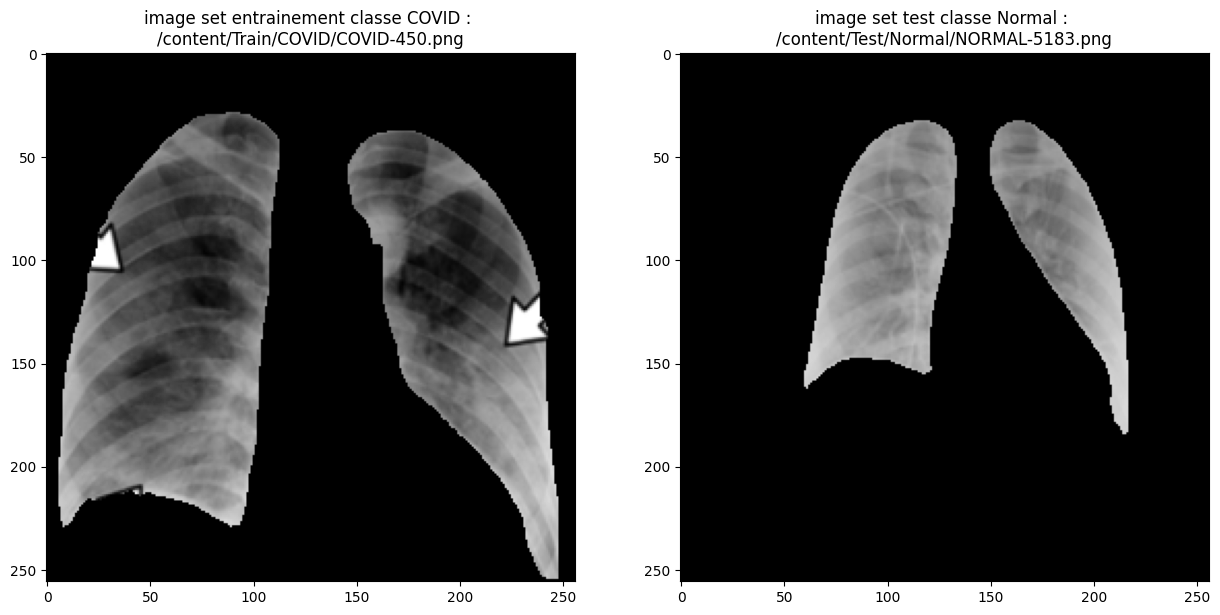

In [6]:
# Vérification basique ouverture + affichage d'une image des sets d'images

fig, axs = plt.subplots(1,2, figsize = (15,15))

# Image du set d'entrainement
COVID = list(train_set_dir.glob('COVID/*'))
img_train_set = cv2.imread(str(COVID[0]), cv2.IMREAD_GRAYSCALE)
axs[0].imshow(img_train_set, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("image set entrainement classe COVID : " + "\n" + str(COVID[0]))

# Image du set de test
Normal = list(test_set_dir.glob('Normal/*'))
img_test_set = cv2.imread(str(Normal[0]), cv2.IMREAD_GRAYSCALE)
axs[1].imshow(img_test_set, cmap = 'gray', vmin = 0, vmax = 255)
axs[1].set_title("image set test classe Normal : " + "\n" + str(Normal[0]))

plt.show()


In [7]:
# Définition de paramètres globaux

batch_size = 32  # valeur "standard" pour des dataset de relatives petites tailles comme sur ce projet
img_height = 256
img_width = 256
validation_split_ratio= 0.2
num_epochs = 15
keras_tuner_logs_dir = "keras_tuner/logs"

In [8]:
# Création des sets d'entrainement et de validation au format keras

# Création du set d'entrainement
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=validation_split_ratio,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  batch_size=batch_size,
)

# Création du set de validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=validation_split_ratio,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  batch_size=batch_size,
 )

Found 4304 files belonging to 4 classes.
Using 3444 files for training.
Found 4304 files belonging to 4 classes.
Using 860 files for validation.


In [9]:
# Vérification du découpage en classes de keras

# Set d'entrainement
train_class_names = train_ds.class_names
print("Classes détectées par KERAS dans le set d'entrainement : ", train_class_names)

# Set de validation
val_class_names = val_ds.class_names
print("Classes détectées par KERAS dans le set de validation : ", val_class_names)

# Création d'une variable globale contenant le nombre de classes
num_classes = len(train_class_names)

Classes détectées par KERAS dans le set d'entrainement :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
Classes détectées par KERAS dans le set de validation :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [10]:
# CELLULE NON UTILISEE

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [11]:
# Définition de la fonction créant un modèle type LeNet et ses hyperparamètres

hp = keras_tuner.HyperParameters()

def build_model(hp):

  Model_LeNet = Sequential([

  #data_augmentation,

  # NORMALISATION DES DONNEES
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),

  # CONVOLUTION 1
  # HYPERPARAMETRAGE NOMBRE FILTRES
  layers.Conv2D(hp.Int('input_units1',min_value=16,max_value=128,step=32),
                5,
                padding='same',
                activation='relu'),
  # POOLING 1
  layers.MaxPooling2D(),

  # CONVOLUTION 2
  # HYPERPARAMETRAGE NOMBRE FILTRES
  layers.Conv2D(hp.Int('input_units2', min_value=16, max_value=128, step=32),
                3,
                padding='same',
                activation='relu'),

  # POOLING 2
  layers.MaxPooling2D(),

  # DROPOUT 1
  # HYPERPARAMETRAGE POURCENTAGE
  layers.Dropout(hp.Float('dropout1', 0, 0.5, step=0.1)),

  # APLATISSEMENT
  layers.Flatten(),

  # DENSE 1
  # HYPERPARAMETRAGE NOMBRE NEURONES
  layers.Dense(units = hp.Choice("units", [32, 64, 128, 256]),
               activation = 'relu', name = "Dense1"),

  # DROPOUT 2
  # HYPERPARAMETRAGE POURCENTAGE
  layers.Dropout(hp.Float('dropout2', 0, 0.5, step=0.1)),

  # DENSE 2
  layers.Dense(units = num_classes,
              activation = 'softmax',
               name = "Dense_final")])

  # LEARNING RATE
  # HYPERPARAMETRAGE VALEUR
  lr = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
  opt = Adam(learning_rate=lr)

  # COMPILATION DU MODELE
  Model_LeNet.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return Model_LeNet


In [12]:
# Instanciation de l'objet keras tuner de type Hyperband

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs = num_epochs,
    hyperband_iterations = 1,
    overwrite = True, # on écrase les données générées précédentes à chaque éxecution
    directory="keras_tuner",
    project_name="results",
    seed=42
)

# Affichage du résumé des hyperparamètres à tuner
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
input_units2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [13]:
# Définition d'une callback qui stoppe le processus d'entrainement quand une valeur monitorée
# (ici la validation loss) stagne pendant un certain nombre d'epochs (et ce à partir d'un certain nombre d'epochs)

callback_early_stopping = EarlyStopping(monitor='val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True,
    start_from_epoch = 3)

In [ ]:
# Recherche par le keras tuner des meilleurs hyperparamètres du modèle

tuner.search(train_ds,
             validation_data=val_ds,
             epochs=num_epochs,
             callbacks = [callback_early_stopping, keras.callbacks.TensorBoard(keras_tuner_logs_dir)])


Trial 17 Complete [00h 01m 48s]
val_accuracy: 0.6918604373931885

Best val_accuracy So Far: 0.6930232644081116
Total elapsed time: 00h 12m 41s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
112               |48                |input_units1
16                |48                |input_units2
0.1               |0.4               |dropout1
128               |64                |units
0                 |0.2               |dropout2
0.001             |0.001             |learning_rate
15                |5                 |tuner/epochs
5                 |2                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |1                 |tuner/round
0012              |0003              |tuner/trial_id



In [ ]:
# Affichage du résumé des résultats du keras tuner

tuner.results_summary()

In [ ]:
# Zip et sauvegarde sur google drive des résultats et logs du keras tuner

!zip -r '/content/drive/MyDrive/Perso/projet_radio/keras_tuner.zip' 'keras_tuner'

In [ ]:
# Sauvegarde (sur google drive) du meilleur modèle sorti du keras tuner

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('/content/drive/MyDrive/Perso/projet_radio/best_model_keras_tuner.keras')

In [ ]:
# Visualisation des résultats intermédiaires de tuning via Tensor Board

# SOIT le tuning a déjà été fait et ses résultats sont stockés sur le drive
# --> on dézippe le contenu stocké sur le drive dans l'environnement du notebook
# --> ligne non commentée
# SOIT le tuning vient d'être fait et ses résultats sont dans l'environnement du notebook
# --> ligne commentée
#!unzip '/content/drive/MyDrive/Perso/projet_radio/keras_tuner.zip'

%load_ext tensorboard
%tensorboard --logdir 'keras_tuner/logs'

In [ ]:
# Création du set de test

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_set_dir,
  image_size=(img_height, img_width),
  color_mode = "grayscale")

In [ ]:
# Calcul d'accuracy sur le set de test

from sklearn.metrics import classification_report
import numpy as np

# On choisit une des 2 lignes suivantes à commenter selon que le modèle a déjà été
# entrainé et stocké sur le drive OU il a été entrainé dans ce notebook plus haut
# pour la première fois
#model = keras.models.load_model('/content/drive/MyDrive/Perso/projet_radio/best_model_keras_tuner.keras')
model = best_model

# Fonction classification_report retourne des valeurs trop basses (environ 25%)
# notamment d'accuracy par rapport aux résultats de l'entrainement (environ 70%)
# Impossible à débugger, même en mettant shuffle à False à la création du dataset
# On utilise donc la fonction evaluate pour l'accuracy
#train_data = np.concatenate([x for x, y in train_ds], axis=0)
#train_label = np.concatenate([y for x, y in train_ds], axis=0)
#test_data = np.concatenate([x for x, y in test_ds], axis=0)
#test_label = np.concatenate([y for x, y in test_ds], axis=0)
#test_pred = model.predict(test_data)
#test_pred_class = test_pred.argmax(axis = 1)
#print(classification_report(test_label, test_pred_class))

loss, accuracy = model.evaluate(test_ds, return_dict=True)